In [2]:
import numpy as np
import scipy
from scipy.sparse import diags, kron, eye
from scipy.sparse.linalg import spsolve


# Problem 1

In [435]:
import numpy as np
N  = 100
xx = np.linspace(0,1,N)
yy = xx
dx = xx[1] - xx[0]
dy = dx
epsilon = dx
dt = .1

In [436]:
def create_1d_laplacian(n):
    """Creates a 1D Laplacian matrix of size n x n."""
    e = np.ones(n)
    diagonals = [-2 * e, e, e]
    laplacian_1d = diags(diagonals, [0, -1, 1], shape=(n, n))
    return laplacian_1d

def create_2d_laplacian(n,h):
    """Creates a sparse 2D Laplacian matrix using Kronecker product."""
    laplacian_1d = create_1d_laplacian(n)
    identity = eye(n)
    
    # Use Kronecker product to create the 2D Laplacian
    laplacian_2d = kron(laplacian_1d, identity) + kron(identity, laplacian_1d)
    return laplacian_2d/(h**2)

def create_1d_laplacian_ls(ls):
    """Creates a 1D Laplacian matrix of size n x n."""
    e = np.array(ls)
    diagonals = [-2 * e, e, e]
    laplacian_1d = diags(diagonals, [0, -1, 1], shape=(len(ls), len(ls)))
    return laplacian_1d

def create_2d_laplacian_ls(ls,h):
    """Creates a sparse 2D Laplacian matrix using Kronecker product."""
    laplacian_1d = create_1d_laplacian(int(np.sqrt(len(ls))))
    identity = diags(ls)
    # Use Kronecker product to create the 2D Laplacian
    laplacian_2d = kron(laplacian_1d, identity) + kron(identity, laplacian_1d)
    return laplacian_2d/(h**2)

In [437]:
from scipy.sparse import csr_matrix

def sparse_laplacian(mask,h):
    """
    Create an N^2 x N^2 sparse Laplacian matrix considering only entries with a mask of 1s.

    Parameters:
        N (int): Dimension of the grid (N x N).
        mask (array-like): Array of 1s and 0s of length N^2.

    Returns:
        coo_matrix: Sparse Laplacian matrix of size (N^2, N^2) with specified entries.
    """
    N = int(np.sqrt(len(mask)))
    # Initialize lists to hold the row indices, column indices, and data values for the Laplacian
    # N = 100
    data = list()
    row_ind = list()
    col_ind = list()
    # i mod 100 for i, j // 100 for j
    f = np.zeros(N*N)
    for i in range(N):
        if mask[i] ==0:
            continue
        for j in range(N):
            if mask[j] == 0:
                continue
            n = j+i*N
            i = n % N
            j = n // N
            f[n] = -2*np.sin(xx[i]) * np.cos(xx[j])
            if i == 0 or i == (N-1)  or j == 0 or j == N-1:
                for ii,jj,kk in zip([1,-4,1,1,1], [n-1,n,n+1,n,n], [n-1,n,n+1,n-N,n+N]):
                    if (kk>=0 and kk < N) or (kk>=0 and True):
                        data.append(ii/(h**2))
                        row_ind.append(n)
                        col_ind.append(kk)

            else:
                for ii,jj,kk in zip([1,-4,1,1,1], [n-1,n,n+1,n,n], [n-1,n,n+1,n-N,n+N]):
                    data.append(ii/(h**2))
                    row_ind.append(n)
                    col_ind.append(kk)

    sparse_matrix = csr_matrix((data,(row_ind,col_ind)),shape=(N*N,N*N))

    # Create the sparse Laplacian matrix in COO format

    return sparse_matrix

In [438]:
def sparse_laplacian(mask, h):
    """
    Create an N^2 x N^2 sparse Laplacian matrix considering only entries with a mask of 1s,
    applying the same Laplacian behavior on boundary and interior points.

    Parameters:
        mask (array-like): Array of 1s and 0s of length N^2, indicating which nodes to include.
        h (float): Grid spacing.
        xx (array-like): Array for generating f values based on position (assumed to be N in length).

    Returns:
        csr_matrix: Sparse Laplacian matrix of size (N^2, N^2) with specified entries.
        f (array-like): Array of modified values based on mask and xx.
    """
    N = int(np.sqrt(len(mask)))  # Calculate the dimension of the grid
    data = []
    row_ind = []
    col_ind = []
    f = np.zeros(N * N)  # Initialize the f array

    for idx in range(N * N):
        i = idx % N      # Row index in the 2D grid
        j = idx // N     # Column index in the 2D grid

        # Check if this node is included by the mask
        if mask[idx] == 0:
            continue

        # Set the value of f based on xx and the mask
        # Central coefficient for the Laplacian (center of stencil)
        data.append(-4 / h**2)
        row_ind.append(idx)
        col_ind.append(idx)

        # Add neighbors (left, right, up, down) if they are within bounds
        if i > 0 and mask[idx - 1] == 1:  # Left neighbor
            data.append(1 / h**2)
            row_ind.append(idx)
            col_ind.append(idx - 1)
        
        if i < N - 1 and mask[idx + 1] == 1:  # Right neighbor
            data.append(1 / h**2)
            row_ind.append(idx)
            col_ind.append(idx + 1)
        
        if j > 0 and mask[idx - N] == 1:  # Up neighbor
            data.append(1 / h**2)
            row_ind.append(idx)
            col_ind.append(idx - N)
        
        if j < N - 1 and mask[idx + N] == 1:  # Down neighbor
            data.append(1 / h**2)
            row_ind.append(idx)
            col_ind.append(idx + N)

    # Create the sparse Laplacian matrix in CSR format
    sparse_matrix = csr_matrix((data, (row_ind, col_ind)), shape=(N * N, N * N))

    return sparse_matrix # Return the Laplacian matrix and f values

In [439]:
import numpy as np
from scipy.sparse import csr_matrix

def sparse_laplacian(mask, h):
    """
    Optimized creation of an N^2 x N^2 sparse Laplacian matrix considering only entries with a mask of 1s,
    applying the same Laplacian behavior on boundary and interior points.

    Parameters:
        mask (array-like): Array of 1s and 0s of length N^2, indicating which nodes to include.
        h (float): Grid spacing.
        xx (array-like): Array for generating f values based on position (assumed to be N in length).

    Returns:
        csr_matrix: Sparse Laplacian matrix of size (N^2, N^2) with specified entries.
        f (array-like): Array of modified values based on mask and xx.
    """
    N = int(np.sqrt(len(mask)))  # Dimension of the grid
    f = np.zeros(N * N)          # Initialize the f array
    
    # Prepare lists to store the sparse matrix entries
    data = []
    row_ind = []
    col_ind = []
    
    # Precompute values for the central and neighboring entries of the Laplacian
    center_value = -4 / h**2
    neighbor_value = 1 / h**2
    
    # Predefine the offsets for neighbors in a flattened array (left, right, up, down)
    neighbor_offsets = [-1, 1, -N, N]
    
    # Calculate the Laplacian only at positions with a `1` in the mask
    active_indices = np.where(mask == 1)[0]
    for idx in np.where(mask==0)[0]:
        row_ind.append(idx)
        col_ind.append(idx)
        data.append(1)
    for idx in active_indices:
        i = idx % N      # Row index in the 2D grid
        j = idx // N     # Column index in the 2D grid


        # Add the center Laplacian coefficient
        data.append(center_value)
        row_ind.append(idx)
        col_ind.append(idx)

        # Apply the Laplacian stencil by adding valid neighbors
        for offset in neighbor_offsets:
            neighbor_idx = idx + offset
            
            # Check if neighbor is within bounds and part of the mask
            if 0 <= neighbor_idx < N * N and mask[neighbor_idx] == 1:
                # Check left/right boundaries for horizontal neighbors
                if offset == -1 and i == 0:
                    continue  # Skip left boundary
                if offset == 1 and i == N - 1:
                    continue  # Skip right boundary
                
                # Add neighbor Laplacian coefficient
                data.append(neighbor_value)
                row_ind.append(idx)
                col_ind.append(neighbor_idx)

    # Create the sparse Laplacian matrix in CSR format directly
    sparse_matrix = csr_matrix((data, (row_ind, col_ind)), shape=(N * N, N * N))

    return sparse_matrix # Return the Laplacian matrix and f values


In [504]:
def sparse_laplacian(mask, h):
    """
    Construct a sparse Laplacian matrix using the Kronecker product, applying a mask to include only specified entries.

    Parameters:
        mask (array-like): Array of 1s and 0s of length N^2, indicating which nodes to include.
        h (float): Grid spacing.
        xx (array-like): Array for generating f values based on position (assumed to be N in length).

    Returns:
        csr_matrix: Sparse Laplacian matrix with specified entries.
        f (array-like): Array of modified values based on mask and xx.
    """
    N = int(np.sqrt(len(mask)))  # Dimension of the grid
    f = np.zeros(N * N)          # Initialize the f array

    # Define the 1D Laplacian for an N-point grid
    main_diag = -2 * np.ones(N)
    off_diag = np.ones(N - 1)
    laplacian_1d = diags([main_diag, off_diag, off_diag], [0, -1, 1], format='csr') / h**2

    # Create 2D Laplacian using Kronecker product
    laplacian_2d = kron(laplacian_1d, eye(N)) + kron(eye(N), laplacian_1d)

    # Apply the mask to keep only specified rows and columns
    active_indices = np.where(mask == 1)[0]
    sparse_laplacian = laplacian_2d[active_indices, :][:, active_indices]

    return sparse_laplacian # Filter f by active indices

In [505]:
np.random.seed(26)
U0 = np.random.random((N,N))
U0 = U0 - np.mean(U0)
lap = create_2d_laplacian_ls([1 for _ in range(N)],dx)
f_prime = lambda x: x**3 - x
u0_flat=U0.reshape(-1,1).flatten()

In [506]:
def forward_euler_step(u,lap,ft,t,step):
    F = ft(t)
    dudt = (lap @ u) + F
    return u + dudt*step

In [507]:
def backward_euler_step(u,lap,step):
    return   u+ step*spsolve(lap, u)



In [508]:
def stencil(array,i,j,N):
    return 0 if i <= 1 or j <= 1 or i >= N-2 or j >= N-2 else (array[i,j] + array[i-1,j] + array[i+1,j]+ array[i,j+1] + array[i,j-1]+ array[i-2,j] + array[i+2,j]+ array[i,j+2] + array[i,j-2])/9

In [509]:
def apply_mask(lap,mask):
    print('start')
    for idx, m in enumerate(mask):
            if m == 0:
                # Zero out the row
                lap[idx, :] = 0
                # Zero out the column
                lap[:, idx] = 0
                lap[idx,idx]=1

        # Remove explicit zero entries to ensure they are treated as sparse
    lap.eliminate_zeros()
    print('end')
    return lap

In [510]:
f = lambda u,dt : np.sign(u)*np.abs(u)*np.exp(dt)/(np.sqrt(1+u**2*(np.exp(2*dt)-1)))

In [513]:
def run_forward_method(u,xx,f,t0,tend,step,tol):
    dx = xx[1]-xx[0]
    t = t0
    ls = list()
    ls.append(u)
    lst = list()
    lst.append(t)
    num_steps = int((tend-t0)//step)
    last_step = tend - num_steps*step - t0
    lap = create_2d_laplacian(len(xx),dx)
    elap = epsilon**2*lap
    solve1 = -1/step*eye(len(u))+epsilon**2*lap
    zeroed_out = np.ones(len(u))
    for _ in range(num_steps):
        u_star = spsolve(solve1,-1*u/step)*zeroed_out
        u_record = u
        u = f(u_star,step)
        u[np.where(zeroed_out ==0)[0]] = u_record[np.where(zeroed_out ==0)[0]]
        # print(type(u))
        # assert(np.mean(np.sign(u)==np.sign(u_star))==1)
        t+= step
        ls.append(u)
        lst.append(t)
        zeroed_out = np.array([stencil(u.reshape((N,N)),n%N,n//N,N) for n in range(N*N)])
        zeroed_out = ((zeroed_out < .99) & (zeroed_out > -.99)) + 0
        lap = sparse_laplacian(zeroed_out,dx)
        # print(lap.shape)
        solve1 = -1/step*eye(len(u))\
            +lap*epsilon**2


    

    u_star = spsolve(solve1,-1*u/step)
    u = f(u_star,step)
    ls.append(u)
    t+= last_step
    lst.append(t)
    return(ls,lst)

In [514]:
uu,tt = run_forward_method(u0_flat,xx,f,0,50,dt,.9)

ValueError: inconsistent shapes

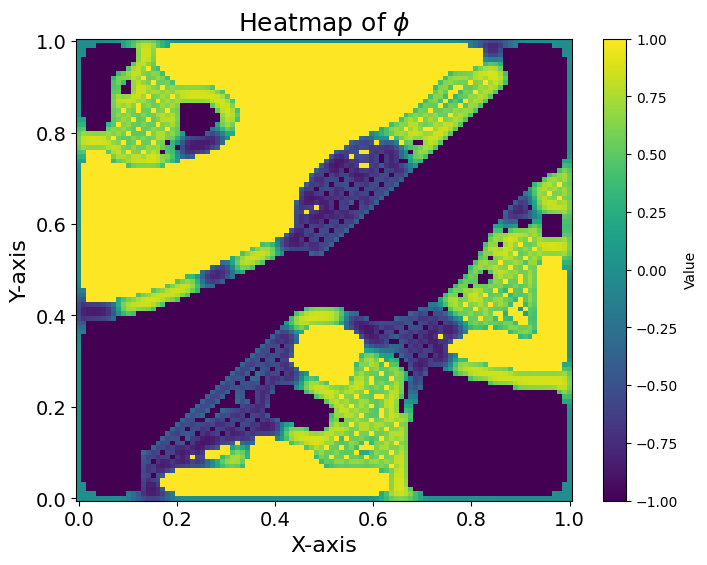

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for demonstration
# x, y = 1D arrays for axis values
# U = 2D array with values
U = uu[-1].reshape(N,N)

plt.figure(figsize=(8, 6))
plt.pcolormesh(xx, yy, U, shading='auto', cmap='viridis')  # Shading 'auto' prevents visual artifacts
plt.colorbar(label='Value')  # Add a color bar to show value scale
plt.xlabel('X-axis',fontsize = 16)
plt.ylabel('Y-axis',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title(r'Heatmap of $\phi$',fontsize = 18)
plt.show()


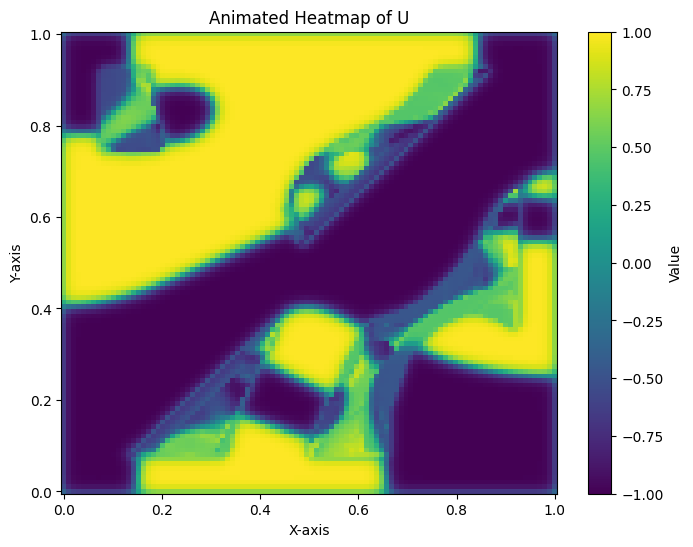

In [ ]:
# Sample grid and initial data
import matplotlib.animation as animation

XX, YY = np.meshgrid(xx, yy)

# Generate random data for demonstration
# Replace this with your actual data generation or loading
astep = len(uu)//30
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.pcolormesh(XX.reshape(N,N), YY.reshape(N,N), uu[0].reshape(N,N), shading='auto', cmap='viridis', vmin = -1, vmax = 1)
fig.colorbar(cax, ax=ax, label='Value')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Animated Heatmap of U')

# Function to update the plot at each frame
def animate(i):
    cax.set_array(uu[i*astep].ravel())  # Update the array for the current frame

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=30, interval=100)  # Adjust interval for speed

# Save the animation as a video fi le (e.g., mp4) or display as a GIF
# ani.save('animated_heatmap.mp4', writer='ffmpeg', dpi=300)  # Save as MP4
# or display inline if using Jupyter Notebook
plt.show()
ani.save('animated_heatmap.gif', writer='pillow', dpi=80)


[-0.08097265022880265, -0.08147598131341625, -0.08136634533716278, -0.08131547942379787, -0.08129192288921024, -0.08128049635208096, -0.08130269207496572, -0.08132051249662278, -0.08128885837305741, -0.0813539167301446, -0.08139923882724524, -0.08139880012424566, -0.08146141481729263, -0.08137862711833677, -0.08116174721584016, -0.08103345593148785, -0.08101473956523692, -0.08086811488368911, -0.08069599682919489, -0.080543110832455, -0.08041783423751592, -0.08025691544977333, -0.08015031854073766, -0.08003088027591676, -0.07987058822610718, -0.07967375817968035, -0.07947202092674666, -0.07926386093634756, -0.07901907517209061, -0.07877025195896845, -0.07857360834060707, -0.07839211920470746, -0.07816497156318081, -0.07795550362008756, -0.07773140179671525, -0.07749387780426521, -0.07727277204225039, -0.07703639266601653, -0.07675752590322327, -0.07646999585574947, -0.0762025247453915, -0.07592298204094289, -0.07563272254226741, -0.07536013648666763, -0.07504543040101441, -0.0746657693

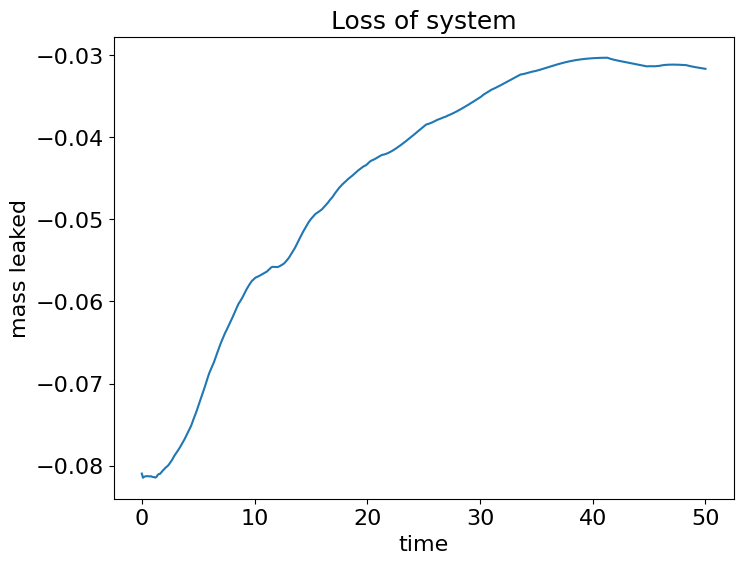

In [516]:
mass = [np.sum(uu[i])*dx*dy for i in range(len(uu))]
print(mass)
print(len(uu))
fig,ax = plt.subplots(figsize=(8, 6))
plt.plot(tt,mass)
ax.set_title('Loss of system',fontsize=18)
ax.set_xlabel('time',fontsize=16)
ax.set_ylabel('mass leaked',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)

# Problem 2

In [ ]:
import numpy as np
N  = 400
xx = np.linspace(0,1,N)
yy = xx
dx = xx[1] - xx[0]
dy = dx
epsilon = dx
dt = 1

In [ ]:
def create_1d_laplacian(n):
    """Creates a 1D Laplacian matrix of size n x n."""
    e = np.ones(n)
    diagonals = [-2 * e, e, e]
    laplacian_1d = diags(diagonals, [0, -1, 1], shape=(n, n))
    return laplacian_1d

def create_2d_laplacian(n,h):
    """Creates a sparse 2D Laplacian matrix using Kronecker product."""
    laplacian_1d = create_1d_laplacian(n)
    identity = eye(n)
    
    # Use Kronecker product to create the 2D Laplacian
    laplacian_2d = kron(laplacian_1d, identity) + kron(identity, laplacian_1d)
    return laplacian_2d/(h**2)

In [ ]:
np.random.seed(69420)
U0 = np.random.random((N,N))
U0 = np.full((N,N),.0 )
U0[:N//4,:N//4]  = -.5
U0[N//4:,N//4:]  = .5
U0 = U0 - np.mean(U0)
lap = create_2d_laplacian(N,dx)
f_prime = lambda x: x**3 - x
u0_flat=U0.reshape(-1,1).flatten()

In [ ]:
def forward_euler_step(u,lap,ft,t,step):
    F = ft(t)
    dudt = (lap @ u) + F
    return u + dudt*step

In [ ]:
def backward_euler_step(u,lap,step):
    return   u+ step*spsolve(lap, u)



In [ ]:
phi_star = lambda u,dt : np.sign(u)*np.abs(u)*np.exp(dt)/(np.sqrt(1+u**2*(np.exp(2*dt)-1)))
F = lambda phi : (phi**2-1)**2/4
F_prime = lambda phi: phi**3 - phi
beta = lambda phi_ss, phi_0 : sum(phi_0 - phi_ss)/sum(np.sqrt(F(phi_ss))) * 1/dt
phi_ss = lambda phi_ss, phi_0 : phi_ss + dt*beta(phi_ss,phi_0)*np.sqrt(F(phi_ss))

In [ ]:
def run_forward_method(u,f,lap,t0,tend,step):
    t = t0
    u0 = u
    ls = list()
    ls.append(u)
    lst = list()
    lst.append(t)
    num_steps = int((tend-t0)//step)
    last_step = tend - num_steps*step - t0
    solve1 = -1/step*eye(len(u))+epsilon**2*lap
    for _ in range(num_steps):
        u_star = spsolve(solve1,-1*u/step)
        u_ss = f(u_star,step)
        u = phi_ss(u_ss,u0)
        t+= step
        ls.append(u)
        lst.append(t)
        # print(u_star,u)
    

    u_star = spsolve(solve1,-1*u/step)
    u_ss = f(u_star,step)
    u = phi_ss(u_ss,u0)

    ls.append(u)
    t+= last_step
    lst.append(t)
    return(ls,lst)

In [ ]:
uu,tt = run_forward_method(u0_flat,f,lap,0,100,dt)

C:\Users\andyh\AppData\Local\Temp\ipykernel_9140\3993574408.py:10: UserWarning: shading value 'bilinear' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  plt.pcolormesh(xx, yy, U, shading='bilinear', cmap='viridis')  # Shading 'auto' prevents visual artifacts


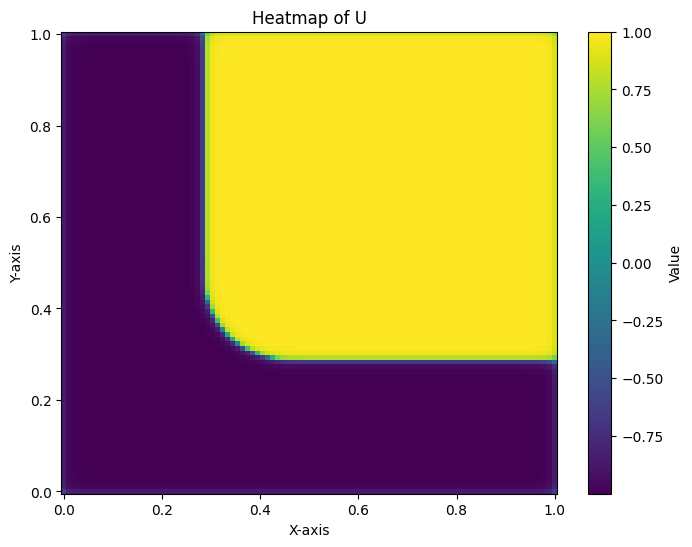

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for demonstration
# x, y = 1D arrays for axis values
# U = 2D array with values
U = uu[-1].reshape(N,N)

plt.figure(figsize=(8, 6))
plt.pcolormesh(xx, yy, U, shading='bilinear', cmap='viridis')  # Shading 'auto' prevents visual artifacts
plt.colorbar(label='Value')  # Add a color bar to show value scale
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Heatmap of U')
plt.show()


In [ ]:
# Interpolate data to add more frames
num_original_frames = len(uu)
interpolation_factor = 1  # Number of extra frames between each original frame
num_frames = num_original_frames * interpolation_factor

uu_interp = []
for i in range(num_original_frames - 1):
    for t in np.linspace(0, 1, interpolation_factor, endpoint=False):
        U_interp = (1 - t) * uu[i] + t * uu[i + 1]
        uu_interp.append(U_interp)
uu_interp.append(uu[-1])  # Add the last frame

C:\Users\andyh\AppData\Local\Temp\ipykernel_9140\3674681304.py:11: UserWarning: shading value 'cubic' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  cax = ax.pcolormesh(XX.reshape(N,N), YY.reshape(N,N), uu_interp[0].reshape(N,N), shading='cubic', cmap='plasma', vmin = -1, vmax = 1)


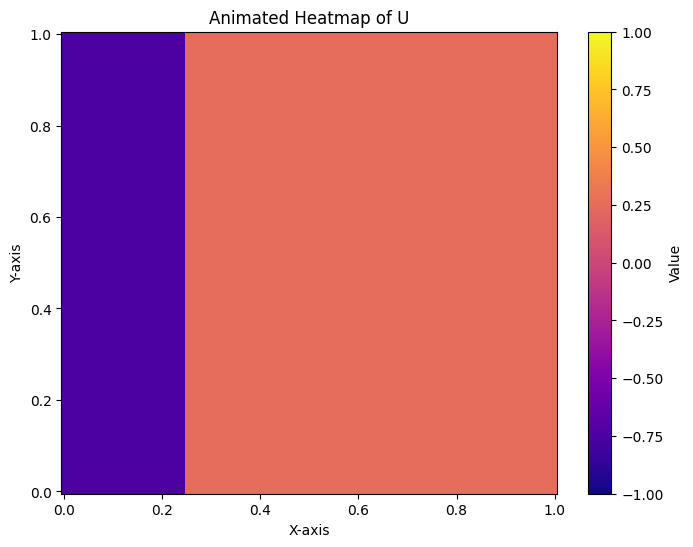

In [ ]:
# Sample grid and initial data
import matplotlib.animation as animation

XX, YY = np.meshgrid(xx, yy)

# Generate random data for demonstration
# Replace this with your actual data generation or loading
frames = 60
astep = len(uu_interp)//frames
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.pcolormesh(XX.reshape(N,N), YY.reshape(N,N), uu_interp[0].reshape(N,N), shading='cubic', cmap='plasma', vmin = -1, vmax = 1)
fig.colorbar(cax, ax=ax, label='Value')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Animated Heatmap of U')

# Function to update the plot at each frame
def animate(i):
    cax.set_array(uu_interp[i*astep].ravel())  # Update the array for the current frame

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=frames, interval=100)  # Adjust interval for speed

# Save the animation as a video file (e.g., mp4) or display as a GIF
# ani.save('animated_heatmap.mp4', writer='ffmpeg', dpi=300)  # Save as MP4
# or display inline if using Jupyter Notebook
plt.show()
ani.save('animated_heatmap.gif', writer='pillow', dpi=80)


In [ ]:
import pandas as pd

In [ ]:
print(pd.DataFrame(uu[-1]).describe())
print((uu[-1]).flatten())
x = uu[-1].flatten()
print(len(x[x > .99])/len(x))
print(len(x[x < -.99])/len(x))

                  0
count  1.600000e+05
mean  -7.031531e-15
std    9.934703e-01
min   -1.000000e+00
25%   -9.999997e-01
50%   -5.868328e-01
75%    1.000000e+00
max    1.000000e+00
[-0.62659981 -0.79304274 -0.83906237 ... -0.83906237 -0.79304274
 -0.62659981]
0.477025
0.4506625


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 50]
[-2.110145259497171e-17, -1.3113897092920272e-17, -3.7672649830570964e-17, 6.994078449557478e-18, -1.6213545496701429e-16, -2.161806066226857e-17, -7.057660980917092e-17, -1.0681865268415058e-16, 6.358253135961344e-18, 3.814951881576807e-17, 3.4080236808752803e-16, 6.688882299031334e-16, 5.474455950062718e-16, 3.458889705962971e-16, 7.439156169074773e-17, 8.456476670828588e-17, -1.2843671334641915e-16, -2.842139151774721e-16, -5.72242782236521e-17, -1.882042928244558e-16, 1.7421613592534082e-16, -4.717823826883318e-16, -3.179126567980672e-17, 3.814951881576807e-17, -2.1872390787707023e-16, 5.0866025087690756e-18, 9.32119909731933e-16, 1.3225166522799596e-16, -4.9594374460498486e-17, -5.518963722014447e-16, -9.016002946793186e-16, 1.0681865268415058e-16, 1.424248702455341e-16, -6.968645437013633e-16, -1.6277128028061042e-16, -4.5

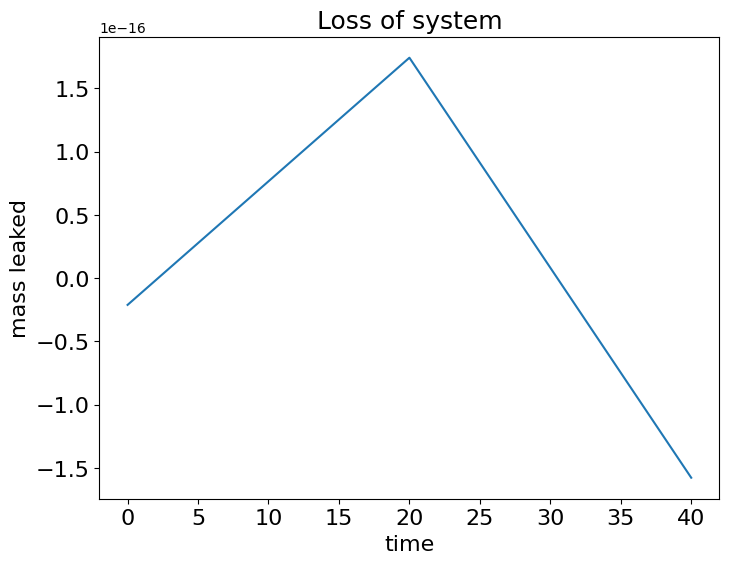

In [ ]:
mass = [np.sum(uu[i])*dx*dy for i in range(len(uu))]
pltmass = [mass[i] for i in range(len(mass) ) if i % 20 == 0]
pltt = [tt[i] for i in range(len(tt) )if i % 20 == 0]
tt = np.round(tt,4)
print(tt)
print(mass)
print(len(uu))
fig,ax = plt.subplots(figsize=(8, 6))
ax.plot(pltt,pltmass)
ax.set_title('Loss of system',fontsize=18)
ax.set_xlabel('time',fontsize=16)
ax.set_ylabel('mass leaked',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)

In [ ]:
def run_forward_method(u,xx,f,t0,tend,step,tol):
    dx = xx[1]-xx[0]
    t = t0
    ls = list()
    ls.append(u)
    lst = list()
    lst.append(t)
    num_steps = int((tend-t0)//step)
    last_step = tend - num_steps*step - t0
    lap = create_2d_laplacian(len(xx),dx)
    elap = epsilon**2*lap
    solve1 = -1/step*eye(len(u))+epsilon**2*lap
    zeroed_out=u
    for _ in range(num_steps):
        u_star = spsolve(solve1,-1*zeroed_out*u/step)
        u = f(u_star,step)
        # print(type(u))
        assert(np.mean(np.sign(u)==np.sign(u_star))==1)
        t+= step
        ls.append(u)
        lst.append(t)
        zeroed_out = np.array([stencil(u.reshape((N,N)),n%N,n//N,N) for n in range(N*N)])
        zeroed_out = ((zeroed_out < 1.99999) & (zeroed_out > -1.99999)) + 0
        # nlap = apply_mask(lap,zeroed_out)
        # # print(lap.shape)
        # print(zeroed_out.shape)
        # print(nlap.shape)

        # solve1 = -1/step*diags(zeroed_out)\
        #     +nlap*epsilon**2
        print(np.mean(zeroed_out))


    

    u_star = spsolve(solve1,-1*u/step)
    u = f(u_star,step)
    ls.append(u)
    t+= last_step
    lst.append(t)
    return(ls,lst)